The following cell ensures that each notebook runs on the same dependencies and versions as all other notebooks in Google Colab.

In [1]:
import os, sys, subprocess
import pathlib
from pathlib import Path
import matplotlib.pyplot as plt

!pip -q install ipywidgets>=8.1
!git clone https://github.com/makinchii/CS156_Project.git /content/CS156_Project
%cd /content/CS156_Project/notebooks

def in_colab() -> bool:
    try:
        import google.colab
        return True
    except Exception:
        return False

REQ_PATH = Path("requirements.txt")
RAW_REQ_URL = os.environ.get(
    "RAW_REQ_URL",
    "https://raw.githubusercontent.com/makinchii/CS156_Project/main/requirements.txt"
)

def run(cmd):
    print("$", " ".join(cmd))
    subprocess.check_call(cmd)

pip = [sys.executable, "-m", "pip"]

if not in_colab() and os.environ.get("VIRTUAL_ENV") is None:
    print("Not in a virtual environment. Consider: python -m venv .venv && activate it.")

# Upgrade pip in the active kernel
run(pip + ["install", "-q", "-U", "pip"])

# Install dependencies
if REQ_PATH.exists():
    run(pip + ["install", "-q", "-r", str(REQ_PATH)])
elif in_colab() and RAW_REQ_URL:
    run(pip + ["install", "-q", "-r", RAW_REQ_URL])
else:
    print("requirements.txt not found. If you're in Colab, set RAW_REQ_URL to your repo's raw requirements.txt, e.g.:")
    print("    os.environ['RAW_REQ_URL'] = 'https://raw.githubusercontent.com/<user>/<repo>/main/requirements.txt'")

# Quick sanity print
try:
    import pandas as pd, numpy as np
    print("Python:", sys.version.split()[0])
    print("pandas:", pd.__version__)
    print("numpy :", np.__version__)
except Exception as e:
    print("(Optional) Could not import pandas/numpy for version check:", e)

fatal: destination path '/content/CS156_Project' already exists and is not an empty directory.
/content/CS156_Project/notebooks
$ /usr/bin/python3 -m pip install -q -U pip
$ /usr/bin/python3 -m pip install -q -r https://raw.githubusercontent.com/makinchii/CS156_Project/main/requirements.txt
Python: 3.12.12
pandas: 2.2.2
numpy : 2.0.2


In [2]:
# import packages
import pandas as pd
import numpy as np
sys.path.insert(0, str((pathlib.Path().resolve() / ".." / "src").resolve()))
from utils import load_dataset

from google.colab import output
output.enable_custom_widget_manager()

In [3]:
# load dataset
df = load_dataset(local_rel_path="data/biosensor_dataset_with_target.csv", raw_url="https://raw.githubusercontent.com/makinchii/CS156_Project/main/data/biosensor_dataset_with_target.csv")

Reading from RAW URL: https://raw.githubusercontent.com/makinchii/CS156_Project/main/data/biosensor_dataset_with_target.csv


In [4]:
# Convert timestamp column
df["Timestamp"] = pd.to_datetime(df["Timestamp"], errors="coerce")

# Sort by time for safety
df = df.sort_values(["Athlete_ID", "Timestamp"])

In [5]:
def plot_signal_window_with_ticks(
    df: pd.DataFrame,
    athlete_id: str,
    event_label: str,
    window_before_s: float = 0.5,
    window_after_s: float = 0.5,
    event_index: int = 0,
    accel_cols = ("Acc_X", "Acc_Y", "Acc_Z"),
    gyro_cols  = ("Gyro_X", "Gyro_Y", "Gyro_Z"),
    heart_col: str = "Heart_Rate",
    show_all_xticks: bool = True,
):
    """
    Draws signal plots around a specific event and labels the vertical line with the event name.
    """

    # ensure datetime & sort
    work = df.copy()
    work["Timestamp"] = pd.to_datetime(work["Timestamp"], errors="coerce")
    subset = work[work["Athlete_ID"] == athlete_id].sort_values("Timestamp")

    # select event occurrence
    events = subset[subset["Event_Label"] == event_label]
    if events.empty or event_index >= len(events):
        return

    event_time = events.iloc[event_index]["Timestamp"]

    # window around event
    start = event_time - pd.Timedelta(seconds=window_before_s)
    end   = event_time + pd.Timedelta(seconds=window_after_s)
    win = subset[(subset["Timestamp"] >= start) & (subset["Timestamp"] <= end)].copy()
    if win.empty:
        return

    # columns to plot
    acc_cols  = [c for c in accel_cols if c in win.columns]
    gyr_cols  = [c for c in gyro_cols if c in win.columns]
    has_hr    = heart_col in win.columns

    nrows = (1 if acc_cols else 0) + (1 if gyr_cols else 0) + (1 if has_hr else 0)
    if nrows == 0:
        return

    fig, axes = plt.subplots(nrows, 1, figsize=(12, 2.6 * nrows), sharex=True)
    if nrows == 1:
        axes = [axes]

    r = 0
    def _plot_block(ycols, title, ylabel):
        nonlocal r
        ax = axes[r]
        for c in ycols:
            ax.plot(win["Timestamp"], win[c], label=c)
        ax.axvline(event_time, linestyle="--", c="r")
        ymax = ax.get_ylim()[1]
        ax.annotate(
            f"{event_label}\n",
            xy=(event_time, ymax),
            xytext=(4, -4),
            textcoords="offset points",
            va="top"
        )
        ax.set_title(title)
        ax.set_ylabel(ylabel)
        ax.legend(loc="best")
        r += 1

    if acc_cols:
        _plot_block(acc_cols, f"{athlete_id} • Accelerometer around {event_label}", "Accel")
    if gyr_cols:
        _plot_block(gyr_cols, f"{athlete_id} • Gyroscope around {event_label}", "Gyro")
    if has_hr:
        _plot_block([heart_col], f"{athlete_id} • Heart Rate around {event_label}", "bpm")

    if show_all_xticks:
        ticks = win["Timestamp"].values
        ticklbls = win["Timestamp"].dt.strftime("%H:%M:%S.%f").str[:-3]
        for ax in axes:
            ax.set_xticks(ticks)
            ax.set_xticklabels(ticklbls, rotation=45, ha="right")

    axes[-1].set_xlabel("Timestamp")
    plt.tight_layout()
    plt.show()

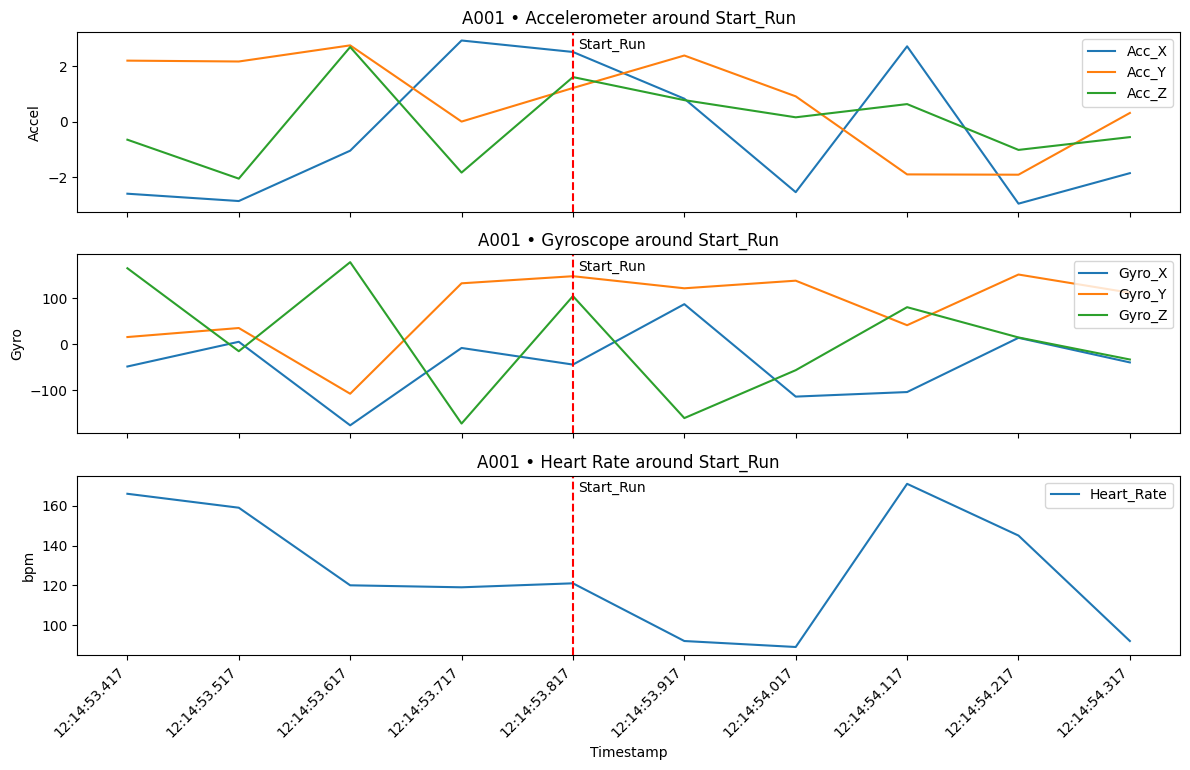

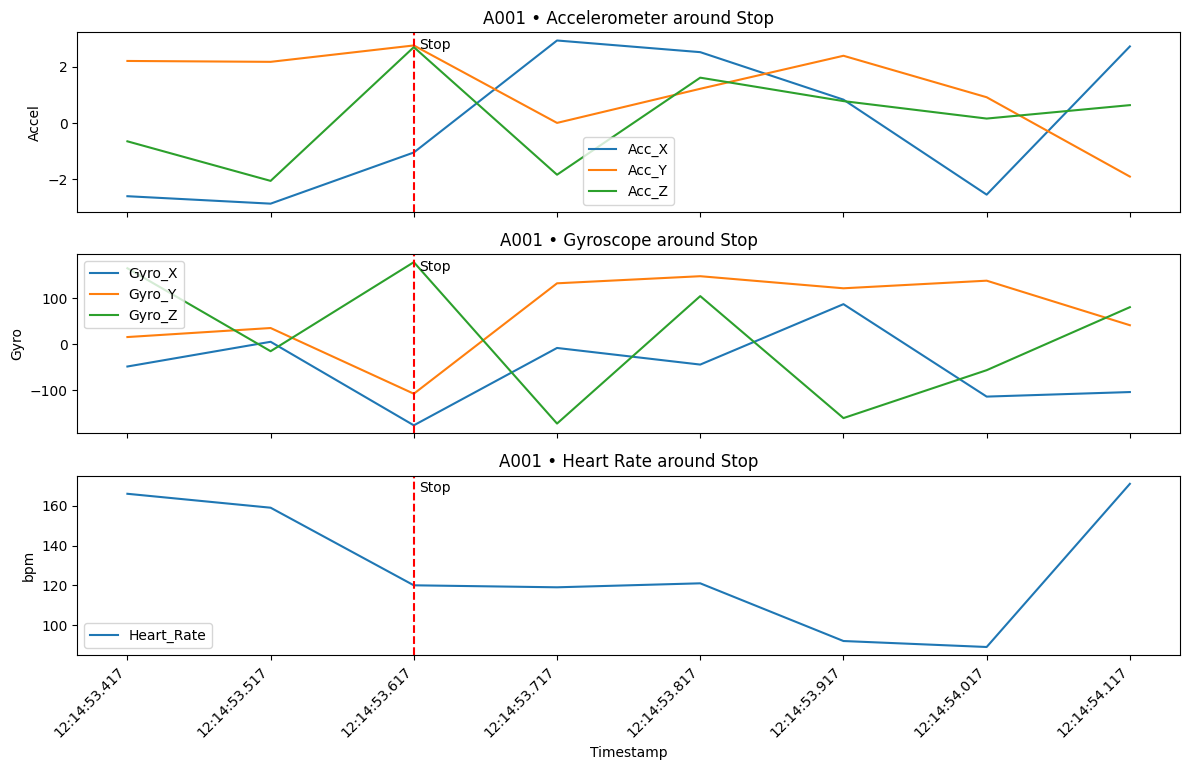

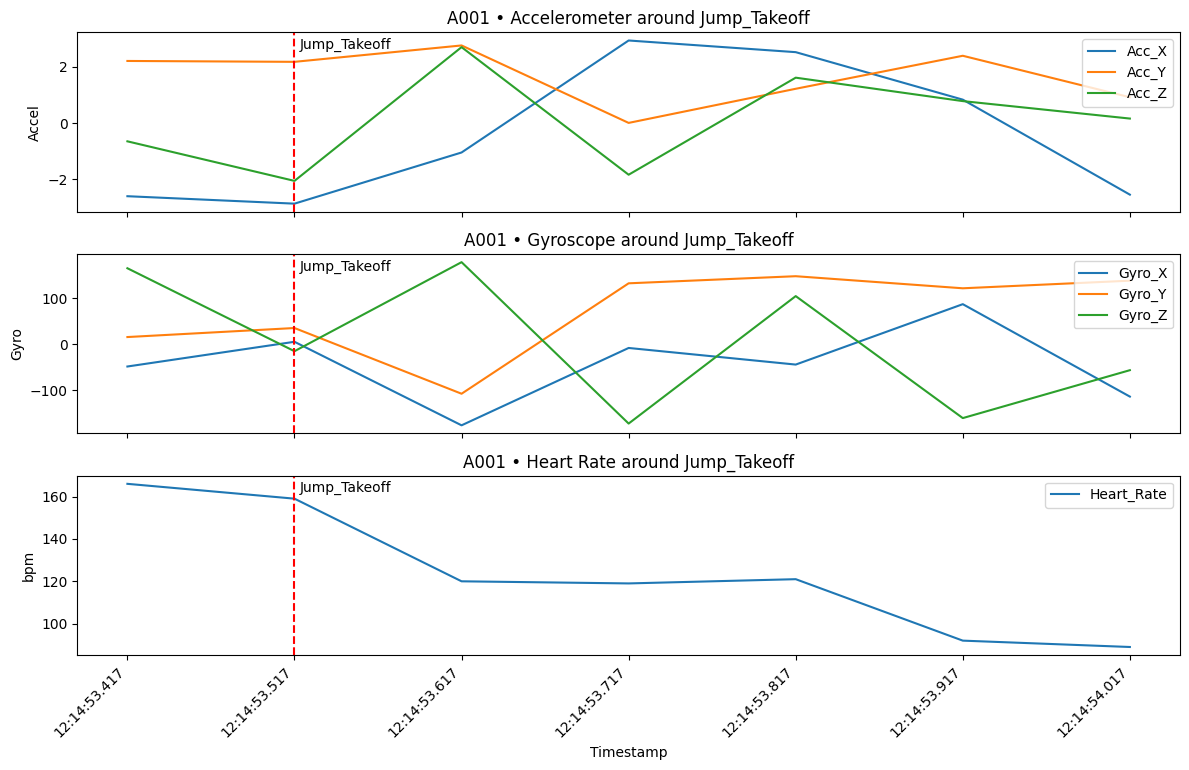

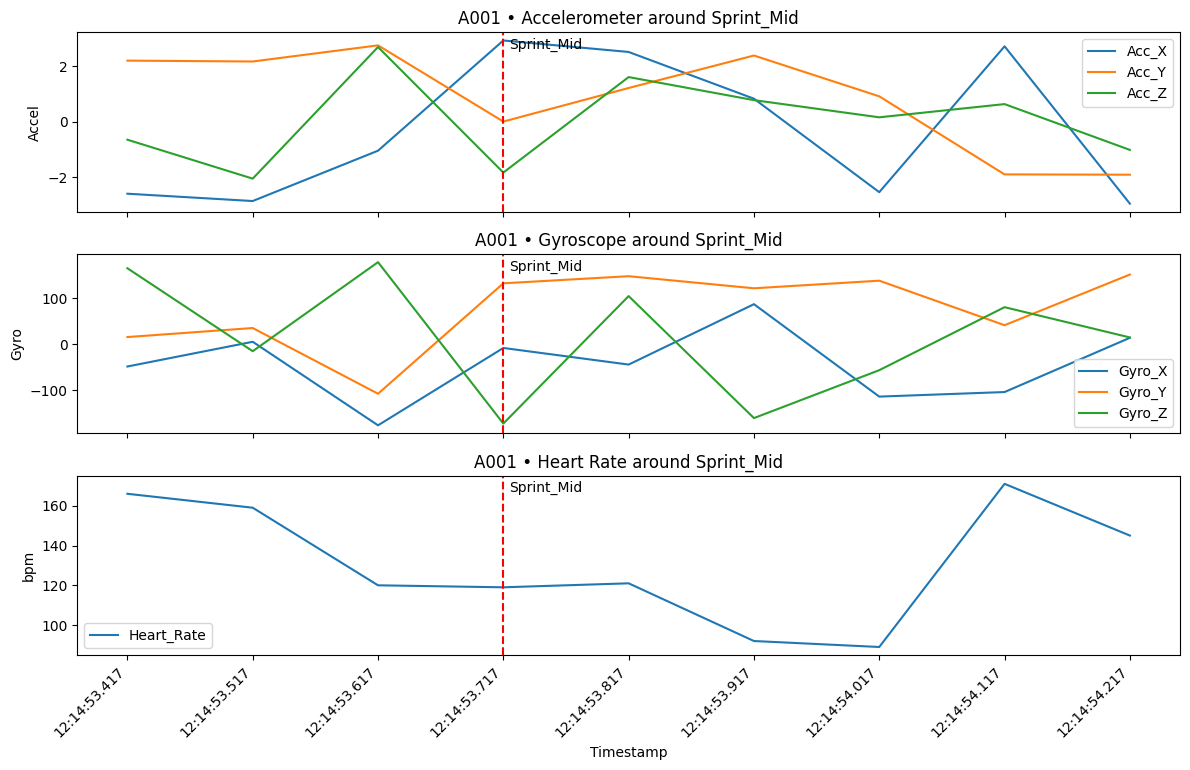

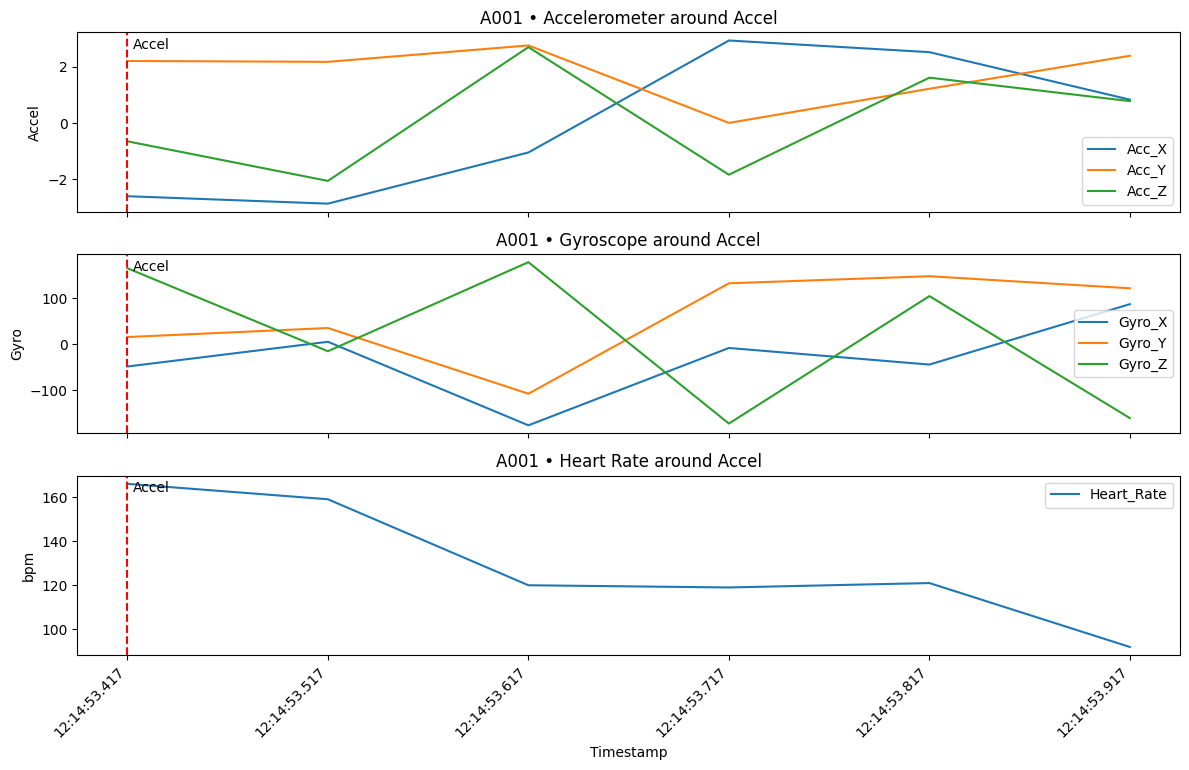

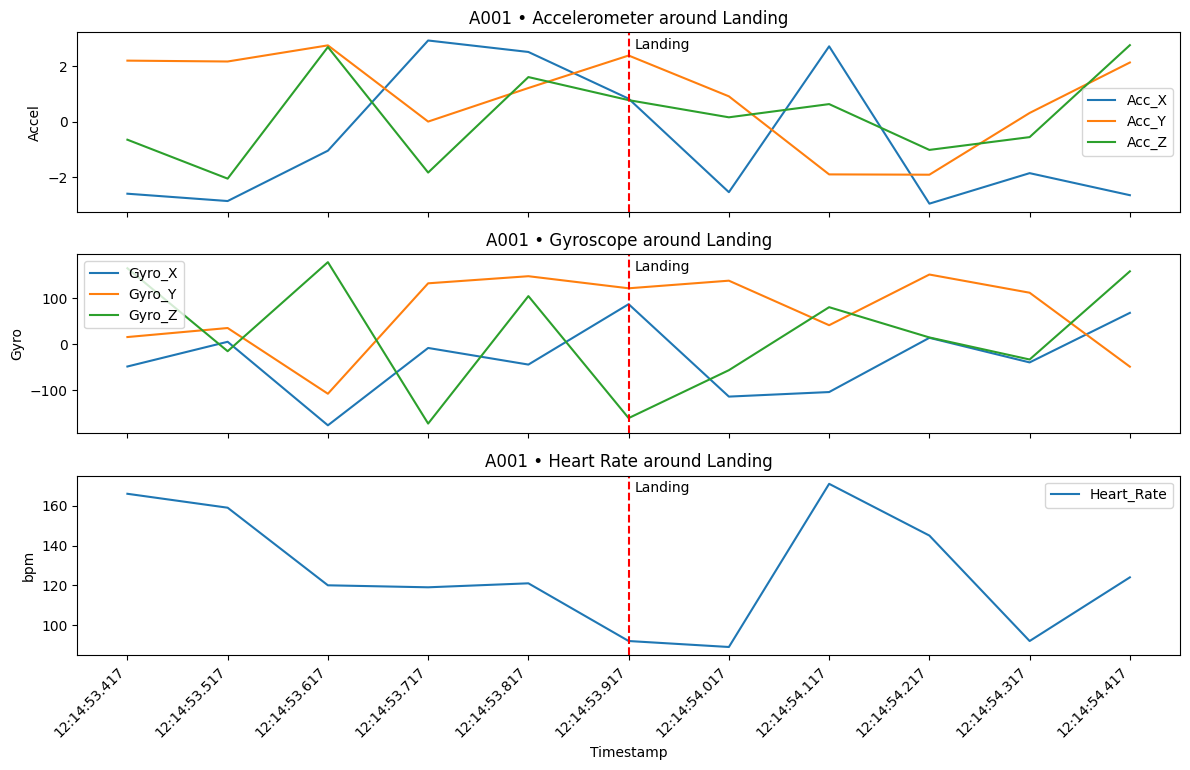

In [6]:
# Plot one example for each

events = ["Start_Run", "Stop", "Jump_Takeoff","Sprint_Mid","Accel","Landing"]

for event in events:
  plot_signal_window_with_ticks(
      df, "A001", event,
      window_before_s=0.5, window_after_s=0.5,
      event_index=0, show_all_xticks=True
  )